# Taxi Trip Duration


- [www.nyc.gov](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)


Install packages


In [1]:
!uv pip install -q \
    python-dotenv==1.2.1 \
    pandas==2.3.2 \
    pandas-stubs==2.3.2.250827 \
    numpy==2.3.2 \
    matplotlib==3.10.6 \
    seaborn==0.13.2 \
    scikit-learn==1.7.1 \
    tqdm==4.67.1 \
    xgboost==3.1.2 \
    pyarrow==22.0.0

Append notebooks directory to sys.path


In [ ]:
import sys

sys.path.append("../../..")

Import packages


In [3]:
import os
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import pickle


pd.set_option("display.max_columns", None)

sns.set_style("darkgrid")
sns.set_theme(style="darkgrid")

%matplotlib inline

Create data directory


In [ ]:
DATA_DIR = pathlib.Path("data/taxi-trip-duration")

os.makedirs(DATA_DIR, exist_ok=True)

Download dataset


In [ ]:
train_file_path = DATA_DIR / "green_tripdata_2021-01.parquet"
train_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
validation_file_path = DATA_DIR / "green_tripdata_2021-02.parquet"
validation_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"


def load_preprocess_data(url, file_path):
    if not file_path.exists():
        df = pd.read_parquet(url, engine="pyarrow")
        df.to_parquet(file_path, engine="pyarrow")
    else:
        df = pd.read_parquet(file_path, engine="pyarrow")

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

    # In minutes
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]

    df[categorical] = df[categorical].astype(str)

    return df


df_train = load_preprocess_data(train_url, train_file_path)
df_validation = load_preprocess_data(validation_url, validation_file_path)

df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,0.5,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [ ]:
len(df_train), len(df_validation)

(73908, 61921)

Duration distribution


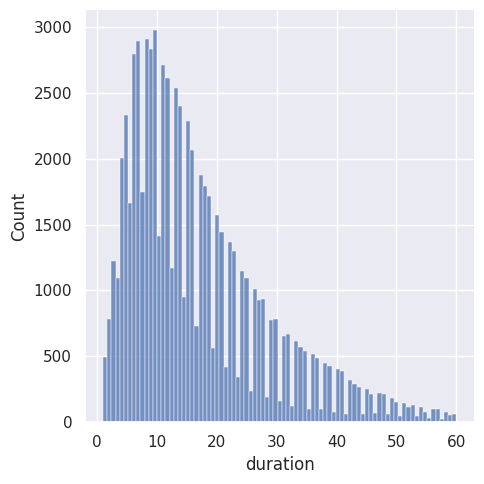

In [ ]:
sns.displot(df_train.duration)
plt.show()

Check statistics measures, due to long tail is difficult to use the distribution chart


In [ ]:
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

One hot encoding


In [ ]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

dict_vectorizer = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dict_vectorizer.fit_transform(train_dicts)

validation_dicts = df_validation[categorical + numerical].to_dict(
    orient="records"
)
X_validation = dict_vectorizer.transform(validation_dicts)

Target


In [ ]:
target = "duration"
y_train = df_train[target].values
y_validation = df_validation[target].values

Train Model


In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
print(linear_regression)

LinearRegression()


Make predictions


In [ ]:
y_validation_pred = linear_regression.predict(X_validation)

Compare predictions to actual values


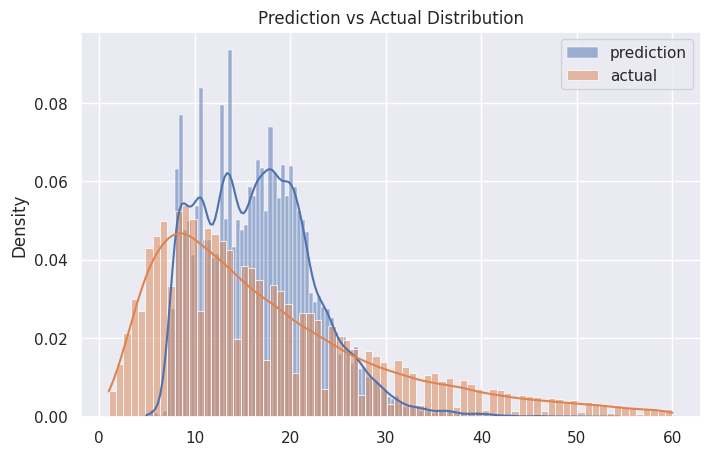

In [ ]:
plt.figure(figsize=(8, 5))

sns.histplot(
    y_validation_pred, label="prediction", kde=True, stat="density", alpha=0.5
)
sns.histplot(y_validation, label="actual", kde=True, stat="density", alpha=0.5)

plt.legend()
plt.title("Prediction vs Actual Distribution")
plt.show()

Calculating RMSE


In [ ]:
root_mean_squared_error(y_validation, y_validation_pred)

10.499110713090017

Lasso model


In [ ]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_validation_pred = lasso.predict(X_validation)

root_mean_squared_error(y_validation, y_validation_pred)

10.481255832615487

Ridge model


In [ ]:
ridge = Ridge(alpha=0.0001)
ridge.fit(X_train, y_train)

y_validation_pred = ridge.predict(X_validation)

root_mean_squared_error(y_validation, y_validation_pred)

10.476414583855084

Define output path


In [ ]:
OUTPUT_DIR = pathlib.Path("artifacts/taxi-trip-duration")

OUTPUT_DIR.mkdir(exist_ok=True)

In [ ]:
output_file = OUTPUT_DIR / f"model.bin"
output_file

PosixPath('artifacts/taxi-trip-duration/model.bin')

Save the model


In [ ]:
with open(output_file, "wb") as f_out:
    pickle.dump((dict_vectorizer, linear_regression), f_out)